# `strategic-fl-sim`: FEMNIST Demo Experiment 

Demonstrating strategic federated learning with adversarial client who upscales their updates

In [2]:
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Import framework components
from femnistdataset import FEMNISTDataset
from torch import nn
from torch.utils.data import DataLoader

from models import CNN
from strategicflsim.agents import Client, Server
from strategicflsim.utils.actions import ScalarAction
from strategicflsim.utils.aggregation import get_aggregate
from strategicflsim.utils.evaluate import evaluate_with_ids
from strategicflsim.utils.metrics import NormMetrics

/Users/dimitar-chakarov/Documents/projects/strategicfl/venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparation/initialization

### Setup device

In [69]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
elif torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple M-series
else:
    device = torch.device("cpu")  # CPU

print(f"Using device: {device}")

Using device: mps


### Setup experiment configuration

In [47]:
config = {
    "training": {
        "T": 3500,  # Number of training rounds
        "lr": 0.06,  # Learning rate
        "local_steps": 3,  # Local SGD steps
        "batch_size": 32,
        "eval_batch_size": 64,
    },
    "clients": {
        "n_players": 10,  # Number of client groups
        "alpha_0": 1.0,  # Good client scaling
        "alpha_1": 1.0,  # Bad client scaling; Not really bad here, this is for illustrative purposes of the functionality of the package
        "beta_0": 0.0,  # Honest client noise
        "beta_1": 0.0,  # Adversarial client noise
    },
    "aggregation": {
        "method": "mean"  # Can be 'mean', 'median', 'trimmed_mean'
    },
    "data": {
        "train_path": "../../data/femnist/train.json",
        "test_path": "../../data/femnist/test.json",
    },
}

print("Configuration:")
for section, values in config.items():
    print(f"  {section}:")
    for key, value in values.items():
        print(f"    {key}: {value}")

Configuration:
  training:
    T: 3500
    lr: 0.06
    local_steps: 3
    batch_size: 32
    eval_batch_size: 64
  clients:
    n_players: 10
    alpha_0: 1.0
    alpha_1: 1.0
    beta_0: 0.0
    beta_1: 0.0
  aggregation:
    method: mean
  data:
    train_path: ../../data/femnist/train.json
    test_path: ../../data/femnist/test.json


### Loading the FEMNIST data

In [7]:
def get_data(path: str):
    with open(path, "r") as f:
        data = json.load(f)
        user_names = list(data.keys())
    return data, user_names


print("\nLoading FEMNIST data...")
data_dict, user_names = get_data(config["data"]["train_path"])
test_data_dict, _ = get_data(config["data"]["test_path"])

print(f"Training data: {len(user_names)} users")
print(f"Sample user data size: {len(data_dict[user_names[0]]['x'])} samples")


Loading FEMNIST data...
Training data: 3597 users
Sample user data size: 139 samples


### Creating a Server agent with CNN model

In [48]:
print("\nCreating server...")
server_model = CNN().to(device)

# Enable compilation for better performance (if available)
if device.type == "cuda":
    server_model = torch.compile(server_model, mode="reduce-overhead")

server = Server(
    device=device,
    model=server_model,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=torch.optim.SGD(server_model.parameters(), lr=config["training"]["lr"]),
    aggregate_fn=get_aggregate(method=config["aggregation"]["method"]),
)

print(f"Created server with {config['aggregation']['method']} aggregation")


Creating server...
Created server with mean aggregation


### Creating a group of Client agents
All but one clients are honest, one client is scaling up their update.

In [49]:
print("\nCreating clients...")
split_index = len(user_names) // config["clients"]["n_players"]
clients = []

for i in range(config["clients"]["n_players"]):
    # Split users among clients
    start_idx = max(0, i * split_index)
    end_idx = min((i + 1) * split_index, len(user_names))
    client_user_names = user_names[start_idx:end_idx]

    # Last client is adversarial, others are honest
    if i == config["clients"]["n_players"] - 1:
        alpha = config["clients"]["alpha_1"]
        beta = config["clients"]["beta_1"]
        agent_id = "selfish"
        print(f"  Client {i + 1}: SELFISH")
    elif i == 6:
        alpha = -config["clients"]["alpha_0"]
        beta = config["clients"]["beta_0"]
        agent_id = "malicious"
        print(f"  Client {i + 1}: MALICIOUS")
    else:
        alpha = config["clients"]["alpha_0"]
        beta = config["clients"]["beta_0"]
        agent_id = f"honest_{i}"
        print(f"  Client {i + 1}: GOOD")

    # Create datasets
    train_dataset = FEMNISTDataset(client_user_names, data_dict)
    test_dataset = FEMNISTDataset(client_user_names, test_data_dict)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config["training"]["batch_size"],
        shuffle=True,
        pin_memory=True if device.type == "cuda" else False,
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=config["training"]["eval_batch_size"],
        shuffle=False,
        pin_memory=True if device.type == "cuda" else False,
    )

    # Create client model
    client_model = CNN().to(device)
    if device.type == "cuda":
        client_model = torch.compile(client_model, mode="reduce-overhead")

    client = Client(
        device=device,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        model=client_model,
        criterion=nn.CrossEntropyLoss().to(device),
        optimizer=torch.optim.SGD(
            client_model.parameters(), lr=config["training"]["lr"]
        ),
        action=ScalarAction(alpha, beta),
        agent_id=agent_id,
    )

    clients.append(client)


Creating clients...
  Client 1: GOOD
  Client 2: GOOD
  Client 3: GOOD
  Client 4: GOOD
  Client 5: GOOD
  Client 6: GOOD
  Client 7: MALICIOUS
  Client 8: GOOD
  Client 9: GOOD
  Client 10: SELFISH


## Run federated training

In [50]:
print(f"\nStarting federated training for {config['training']['T']} rounds...")

# all_losses, all_metrics = server.train(
#     clients=clients,
#     T=config["training"]["T"],
#     get_metrics=get_gradient_metrics,
# )

server.train(
    clients=clients,
    T=config["training"]["T"],
    metrics_fn=NormMetrics(
        save_path="./results/femnist_malicious_6_mean",
        client_ids=[client.agent_id for client in clients],
    ),
)

print("Training completed!")


Starting federated training for 3500 rounds...


Federated Training: 100%|██████████| 3500/3500 [06:38<00:00,  8.78it/s]

Training completed!


## Evaluate final performance

In [51]:
print("\nEvaluating final performance...")
final_accuracy, final_loss = evaluate_with_ids(server, clients)


Evaluating final performance...
honest_0: Accuracy = 0.8115, Loss = 0.5360
honest_1: Accuracy = 0.8131, Loss = 0.5714
honest_2: Accuracy = 0.8124, Loss = 0.5861
honest_3: Accuracy = 0.8382, Loss = 0.5348
honest_4: Accuracy = 0.8148, Loss = 0.5527
honest_5: Accuracy = 0.8245, Loss = 0.5318
malicious: Accuracy = 0.8701, Loss = 0.4211
honest_7: Accuracy = 0.7972, Loss = 0.6175
honest_8: Accuracy = 0.8186, Loss = 0.5638
selfish: Accuracy = 0.8641, Loss = 0.4483


In [3]:
final_loss_honest = {
    "good0": 0.45847509342402754,
    "good1": 0.5617554185603268,
    "good2": 0.5966092478078334,
    "malicious": 0.34805286258016904,
    "good3": 0.5409728778237677,
    "good4": 0.5047168614066552,
    "good5": 0.4521957796530705,
    "good7": 0.5262003344416759,
    "good8": 0.5171170161810867,
    "bad": 0.45400302652683777,
}

In [4]:
final_loss_selfish = {
    "good0": 0.5266503261856479,
    "good1": 0.5039266959806198,
    "good2": 0.5083861180402879,
    "malicious": 0.3420040108330095,
    "good3": 0.4621285551434655,
    "good4": 0.5202601193757022,
    "good5": 0.4873660470124515,
    "good7": 0.5724580184931549,
    "good8": 0.503484283432238,
    "bad": 0.37462614652335624,
}

In [5]:
final_loss_malicious_6_selfish = {
    "honest_0": 0.47771684403505343,
    "honest_1": 0.5540080468094649,
    "honest_2": 0.582253387547136,
    "malicious": 0.3730333176925648,
    "honest_4": 0.5339031761520869,
    "honest_5": 0.5157268916846292,
    "honest_6": 0.47259951673113915,
    "honest_7": 0.5679551178450619,
    "honest_8": 0.5285884206277504,
    "selfish": 0.4317643266136797,
}

In [6]:
final_loss_malicious_6 = {
    "honest_0": 0.5359825695985273,
    "honest_1": 0.5714208651274444,
    "honest_2": 0.5861421254429292,
    "malicious": 0.4210970844720192,
    "honest_4": 0.5348211134214239,
    "honest_5": 0.5527159741547389,
    "honest_6": 0.5317738757260844,
    "honest_7": 0.6175402795227413,
    "honest_8": 0.5637686318395241,
    "selfish": 0.4482537076907517,
}

In [7]:
final_loss

NameError: name 'final_loss' is not defined

## Visualize training process

In [8]:
sns.color_palette(palette="tab20c")

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

Figure saved as './results/femnist_diff_client_populations.pdf'


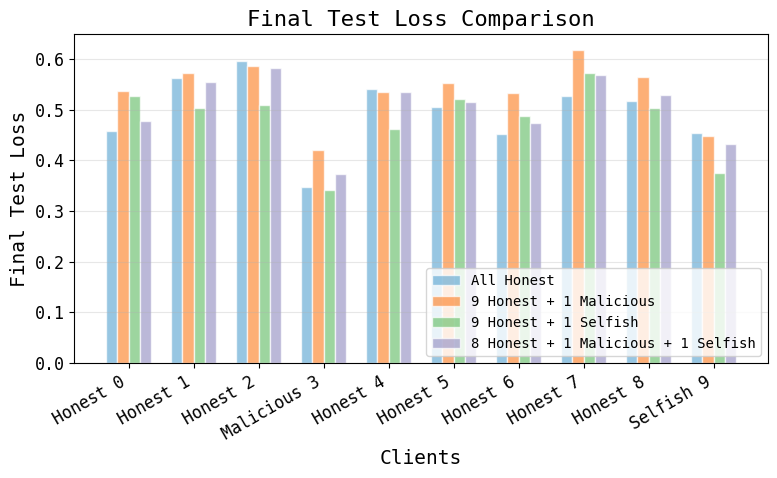

In [19]:
plt.rcParams.update(
    {
        "font.family": "monospace",
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
)

# Color scheme
color_palette = sns.color_palette(palette="tab20c")
color_good = color_palette[1]  # light blue
color_malicious = color_palette[5]  # light orange
color_selfish = color_palette[9]  # light orange
color_malicious_selfish = color_palette[13]  # light orange

# Final loss comparison
client_ids = list(final_loss_honest.keys())
losses_honest_final = [float(final_loss_honest[cid]) for cid in client_ids]
losses_malicious_final = [
    float(final_loss_malicious_6[cid]) for cid in list(final_loss_malicious_6.keys())
]
losses_selfish_final = [float(final_loss_selfish[cid]) for cid in client_ids]
losses_malicious_selfish_final = [
    float(final_loss_malicious_6_selfish[cid])
    for cid in list(final_loss_malicious_6_selfish.keys())
]


x = np.arange(len(client_ids))
width = 0.175

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    x - 1.5 * width,
    losses_honest_final,
    width,
    label="All Honest",
    color=color_good,
    alpha=0.7,
    edgecolor="white",
)
ax.bar(
    x - 0.5 * width,
    losses_malicious_final,
    width,
    label="9 Honest + 1 Malicious",
    color=color_malicious,
    alpha=0.7,
    edgecolor="white",
)
ax.bar(
    x + 0.5 * width,
    losses_selfish_final,
    width,
    label="9 Honest + 1 Selfish",
    color=color_selfish,
    alpha=0.7,
    edgecolor="white",
    # hatch="//",
)
ax.bar(
    x + 1.5 * width,
    losses_malicious_selfish_final,
    width,
    label="8 Honest + 1 Malicious + 1 Selfish",
    color=color_malicious_selfish,
    alpha=0.7,
    edgecolor="white",
    # hatch="//",
)

ax.set_xlabel("Clients")
ax.set_ylabel("Final Test Loss")
ax.set_title("Final Test Loss Comparison")
ax.set_xticks(x)

for i in range(len(client_ids) - 1):
    client_ids[i] = f"Honest {i}"
client_ids[3] = "Malicious 3"
client_ids[-1] = "Selfish 9"

ax.set_xticklabels(client_ids, rotation=30, ha="right")
ax.legend(loc="lower right", fontsize=10)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
fig_filename = "./results/femnist_diff_client_populations"
plt.savefig(f"{fig_filename}.pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved as '{fig_filename}.pdf'")
plt.show()

In [13]:
final_losses_mixture_20 = {
    "good0": 1.8260119448396575,
    "good1": 1.885649846591086,
    "good2": 2.0880871021355705,
    "good3": 2.5630241108212033,
    "good4": 2.5851481996561456,
    "good5": 2.5791956588095717,
    "good6": 2.518230703419042,
    "good7": 2.5578712430580475,
    "good8": 2.2450157200278915,
    "good9": 1.8485843273147522,
    "good10": 1.8883902341501524,
    "good11": 1.9166334599447965,
    "good12": 1.8932020785414214,
    "good13": 1.921987257335901,
    "good14": 1.9933303941319853,
    "good15": 2.0462328469972233,
    "good16": 2.0065910361629458,
    "good17": 2.3239056216911886,
    "good18": 2.3449109831317716,
    "bad": 2.381379021728349,
}

In [14]:
final_losses_honest_20 = {
    "good0": 1.4722265310696483,
    "good1": 1.5359505211276772,
    "good2": 1.676818110404313,
    "good3": 2.001234459341835,
    "good4": 2.0234536688048625,
    "good5": 2.0172748844699653,
    "good6": 1.939232674011044,
    "good7": 1.980897159843319,
    "good8": 1.791159971868408,
    "good9": 1.496223932193465,
    "good10": 1.5499825960177032,
    "good11": 1.4526057059555544,
    "good12": 1.4081689032509765,
    "good13": 1.4327165937647413,
    "good14": 1.6510381302344832,
    "good15": 1.831420732889865,
    "good16": 1.8063443692606846,
    "good17": 1.8236565897755992,
    "good18": 1.7743209031332687,
    "bad": 1.8196728367020039,
}

Figure saved as './results/femnist_20_comparison.pdf'


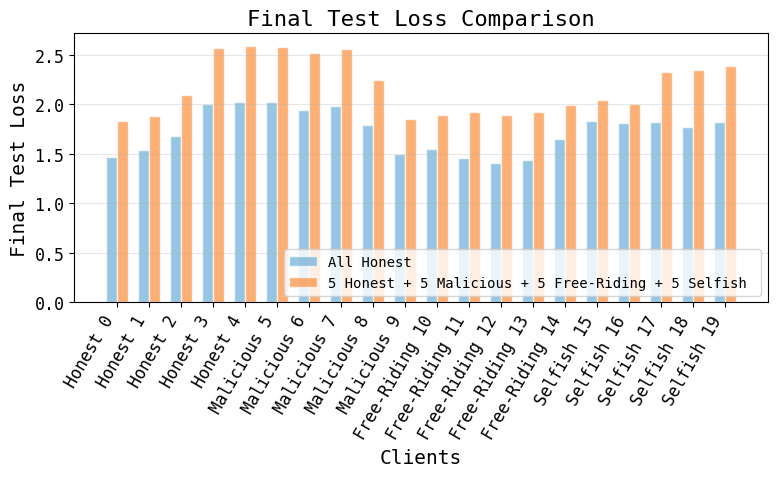

In [17]:
plt.rcParams.update(
    {
        "font.family": "monospace",
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
)

# Color scheme
color_palette = sns.color_palette(palette="tab20c")
color_good = color_palette[1]  # light blue
color_mixture = color_palette[5]  # light orange

# Final loss comparison
client_ids = list(final_losses_honest_20.keys())
losses_mixture_final = [
    float(final_losses_mixture_20[cid]) for cid in list(final_losses_mixture_20.keys())
]
losses_honest_final = [
    float(final_losses_honest_20[cid]) for cid in list(final_losses_honest_20.keys())
]

x = np.arange(len(client_ids))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    x - 0.5 * width,
    losses_honest_final,
    width,
    label="All Honest",
    color=color_good,
    alpha=0.7,
    edgecolor="white",
)
ax.bar(
    x + 0.5 * width,
    losses_mixture_final,
    width,
    label="5 Honest + 5 Malicious + 5 Free-Riding + 5 Selfish ",
    color=color_mixture,
    alpha=0.7,
    edgecolor="white",
    # hatch="//",
)

ax.set_xlabel("Clients")
ax.set_ylabel("Final Test Loss")
ax.set_title("Final Test Loss Comparison")
ax.set_xticks(x)

for i in range(5):
    client_ids[i] = f"Honest {i}"
for i in range(5, 10):
    client_ids[i] = f"Malicious {i}"
for i in range(10, 15):
    client_ids[i] = f"Free-Riding {i}"
for i in range(15, 20):
    client_ids[i] = f"Selfish {i}"
# client_ids[3] = "Malicious"
# client_ids[-1] = "Selfish"

ax.set_xticklabels(client_ids, rotation=60, ha="right")
ax.legend(loc="lower right", fontsize=10)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
fig_filename = "./results/femnist_20_comparison"
plt.savefig(f"{fig_filename}.pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved as '{fig_filename}.pdf'")
plt.show()

Figure saved as './results/femnist_scaling_comparison.pdf'


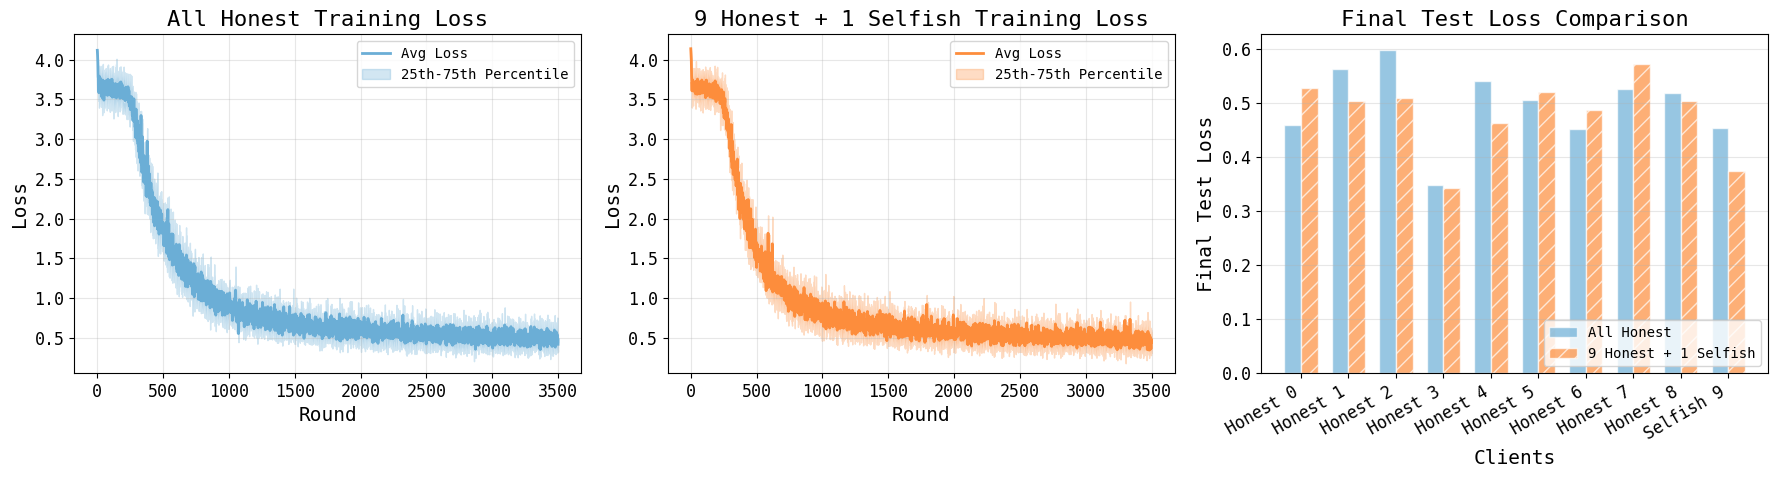

In [20]:
def load_run_data(save_name):
    """Load metrics for a single run."""
    losses_df = pd.read_csv(f"{save_name}_losses.csv")
    rounds = losses_df["round"].values
    losses_array = losses_df.drop("round", axis=1).values
    return rounds, losses_array


plt.rcParams.update(
    {
        "font.family": "monospace",
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
)

# Color scheme - Paired palette (colorblind-safe)
color_palette = sns.color_palette(palette="tab20c")
color_good = color_palette[1]  # light blue
color_bad = color_palette[5]  # light orange

# Load both runs
save_name_honest = "./results/femnist_honest_mean"
save_name_byz = "./results/femnist_scaling_mean"

rounds_honest, losses_honest = load_run_data(save_name_honest)
rounds_byz, losses_byz = load_run_data(save_name_byz)

# Calculate statistics for both
mean_honest = losses_honest.mean(axis=1)
p25_honest = np.percentile(losses_honest, 25, axis=1)
p75_honest = np.percentile(losses_honest, 75, axis=1)

mean_byz = losses_byz.mean(axis=1)
p25_byz = np.percentile(losses_byz, 25, axis=1)
p75_byz = np.percentile(losses_byz, 75, axis=1)

# Calculate shared y-axis limits
all_losses = np.concatenate([losses_honest.flatten(), losses_byz.flatten()])
y_min, y_max = all_losses.min(), all_losses.max()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Honest training loss
axes[0].plot(
    rounds_honest, mean_honest, label="Avg Loss", color=color_good, linewidth=2
)
axes[0].fill_between(
    rounds_honest,
    p25_honest,
    p75_honest,
    alpha=0.3,
    color=color_good,
    label="25th-75th Percentile",
)
axes[0].set_ylim(y_min, y_max)
axes[0].set_title("All Honest Training Loss")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Loss")
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3, which="both")

# Plot 2: Byzantine training loss
axes[1].plot(rounds_byz, mean_byz, label="Avg Loss", color=color_bad, linewidth=2)
axes[1].fill_between(
    rounds_byz,
    p25_byz,
    p75_byz,
    alpha=0.3,
    color=color_bad,
    label="25th-75th Percentile",
)
axes[1].set_ylim(y_min, y_max)
axes[1].set_title("9 Honest + 1 Selfish Training Loss")
axes[1].set_xlabel("Round")
axes[1].set_ylabel("Loss")
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3, which="both")

# Plot 3: Final loss comparison - grouped bars
client_ids = list(final_loss_honest.keys())
losses_honest_final = [float(final_loss_honest[cid]) for cid in client_ids]
losses_byz_final = [float(final_loss_selfish[cid]) for cid in client_ids]

x = np.arange(len(client_ids))
width = 0.35

axes[2].bar(
    x - width / 2,
    losses_honest_final,
    width,
    label="All Honest",
    color=color_good,
    alpha=0.7,
    edgecolor="white",
)
axes[2].bar(
    x + width / 2,
    losses_byz_final,
    width,
    label="9 Honest + 1 Selfish",
    color=color_bad,
    alpha=0.7,
    edgecolor="white",
    hatch="//",
)

axes[2].set_xlabel("Clients")
axes[2].set_ylabel("Final Test Loss")
axes[2].set_title("Final Test Loss Comparison")
axes[2].set_xticks(x)
for i in range(len(client_ids) - 1):
    client_ids[i] = f"Honest {i}"
client_ids[-1] = "Selfish 9"
axes[2].set_xticklabels(client_ids, rotation=30, ha="right")
axes[2].legend(loc="lower right", fontsize=10)
axes[2].grid(axis="y", alpha=0.3)

plt.tight_layout()
fig_filename = "./results/femnist_scaling_comparison"
plt.savefig(f"{fig_filename}.pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved as '{fig_filename}.pdf'")
plt.show()

Figure saved as 'femnist_training_metrics.png'


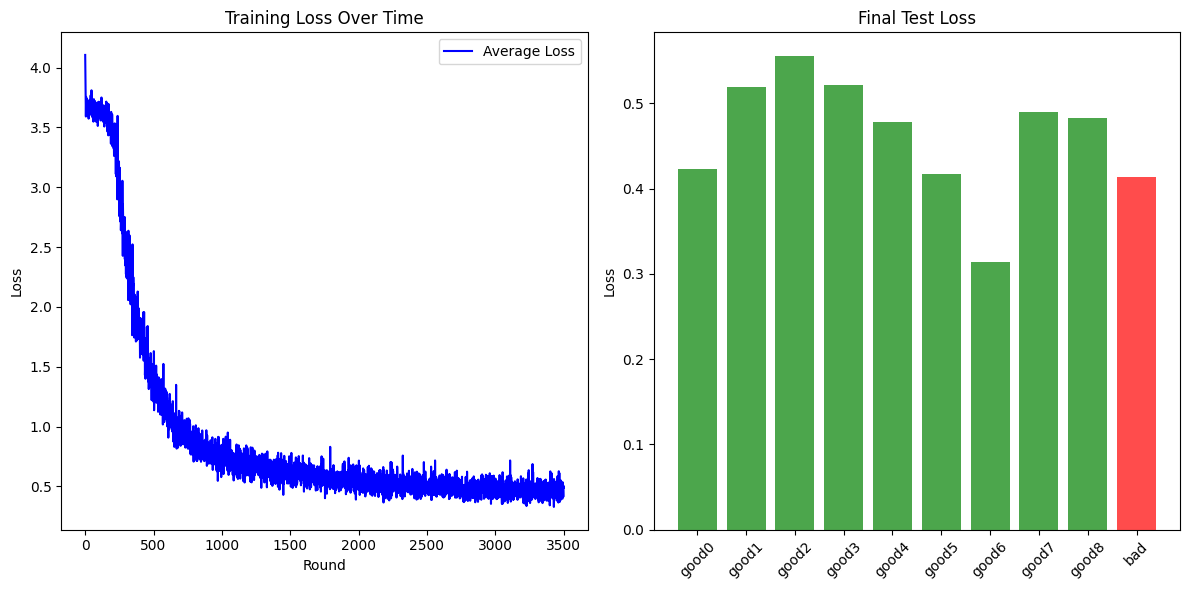

In [ ]:
losses_array = np.array(
    [[loss for loss in round_losses] for round_losses in all_losses]
)
grad_norms_array = np.array([metrics["grad_norms"] for metrics in all_metrics])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training losses over time
axes[0].plot(losses_array.mean(axis=1), label="Average Loss", color="blue")

axes[0].set_title("Training Loss Over Time")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Final loss bar plot
client_ids = list(final_loss.keys())
loss = [float(final_loss[client_id]) for client_id in client_ids]
colors = [
    "red"
    if "adversarial" in client_id.lower() or "bad" in client_id.lower()
    else "green"
    for client_id in client_ids
]
axes[1].bar(client_ids, loss, color=colors, alpha=0.7)
axes[1].set_title("Final Test Loss")
axes[1].set_ylabel("Loss")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()

# Save the figure to file
fig_filename = "femnist_training_metrics"
plt.savefig(f"{fig_filename}.png", dpi=300, bbox_inches="tight")
print(f"Figure saved as '{fig_filename}.png'")

plt.show()

### [Optional] Saving the results

In [ ]:
results = {
    "config": config,
    "final_accuracy": final_accuracy,
    "final_loss": final_loss,
    "training_losses": losses_array,
    "gradient_norms": grad_norms_array,
}

with open("strategicflsim_demo_femnist.pkl", "wb") as f:
    pickle.dump(results, f)
print("Results saved to strategicflsim_demo_femnist.pkl")